In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [20]:
LOCKER_NAME = "508-1"
LOCKER_SIZE = "L"
SIZE_FEATURE = f"size_{LOCKER_SIZE}_counts"
df = pd.read_csv(f'dataset/lockers/{LOCKER_NAME}.csv')
df['Delivery Date Hour'] = pd.to_datetime(df['Delivery Date Hour'])
df.set_index('Delivery Date Hour', inplace=True)

# Resample to 3-hour intervals, summing the counts
df = df.resample('3h').sum().reset_index()
# Add lag features
df['lag_1'] = df[SIZE_FEATURE].shift(1)
df['lag_2'] = df[SIZE_FEATURE].shift(2)
# Calculate hours since last record
# df['hours_since_last'] = df['Delivery Date Hour'].diff().dt.total_seconds() / 3600
# df = df.fillna(0)

df = df.fillna(0)
df['Delivery Hour'] = df['Delivery Date Hour'].dt.hour
df['Delivery Day of Week'] = df['Delivery Date Hour'].dt.dayofweek
df['Delivery Month'] = df['Delivery Date Hour'].dt.month
df['IsBusinessHour'] = df['Delivery Date Hour'].apply(lambda x: 1 if 9 <= x.hour <= 17 else 0)
df['IsBusinessHour'] = df['Delivery Date Hour'].apply(lambda x: 1 if 9 <= x.hour <= 17 else 0)
df['IsWeekend'] = df['Delivery Date Hour'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

df.drop(columns=['IsIndoor'], inplace=True)
df.head()

,Delivery Date Hour,Delivery Hour,Delivery Day of Week,Delivery Month,size_L_counts,size_M_counts,size_S_counts,size_XL_counts,lag_1,lag_2,IsBusinessHour,IsWeekend
0,2024-04-10 18:00:00,18,2,4,1.0,2.0,9.0,0.0,0.0,0.0,0,0
1,2024-04-10 21:00:00,21,2,4,0.0,0.0,0.0,0.0,1.0,0.0,0,0
2,2024-04-11 00:00:00,0,3,4,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,2024-04-11 03:00:00,3,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,2024-04-11 06:00:00,6,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0,0


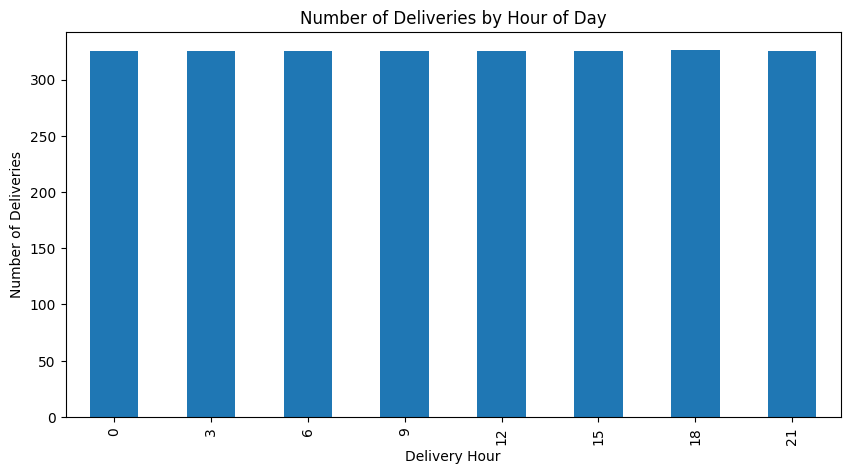

In [21]:
df.groupby('Delivery Hour').size().plot(kind='bar', figsize=(10, 5))
plt.xlabel('Delivery Hour')
plt.ylabel('Number of Deliveries')
plt.title('Number of Deliveries by Hour of Day')
plt.show()


# Preprocessing

Enrich
1. Working hours
2. Holiday
3. Weather

In [22]:
df['lag_1'] = df[SIZE_FEATURE].shift(1)
df['lag_2'] = df[SIZE_FEATURE].shift(2)
df.fillna(0, inplace=True)
df.head()

,Delivery Date Hour,Delivery Hour,Delivery Day of Week,Delivery Month,size_L_counts,size_M_counts,size_S_counts,size_XL_counts,lag_1,lag_2,IsBusinessHour,IsWeekend
0,2024-04-10 18:00:00,18,2,4,1.0,2.0,9.0,0.0,0.0,0.0,0,0
1,2024-04-10 21:00:00,21,2,4,0.0,0.0,0.0,0.0,1.0,0.0,0,0
2,2024-04-11 00:00:00,0,3,4,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,2024-04-11 03:00:00,3,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,2024-04-11 06:00:00,6,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0,0


Cyclical encoding

In [23]:
MONTHS_IN_YEAR = 12
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 7

df['hour_sin'] = np.sin(2 * np.pi * df['Delivery Hour'] / HOURS_IN_DAY)
df['hour_cos'] = np.cos(2 * np.pi * df['Delivery Hour'] / HOURS_IN_DAY)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['Delivery Day of Week'] / DAYS_IN_WEEK)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['Delivery Day of Week'] / DAYS_IN_WEEK)
df['month_sin'] = np.sin(2 * np.pi * df['Delivery Month'] / MONTHS_IN_YEAR)
df['month_cos'] = np.cos(2 * np.pi * df['Delivery Month'] / MONTHS_IN_YEAR)

df2 = df.drop(columns=['Delivery Hour', 'Delivery Day of Week', 'Delivery Month'])
df2.head()

,Delivery Date Hour,size_L_counts,size_M_counts,size_S_counts,size_XL_counts,lag_1,lag_2,IsBusinessHour,IsWeekend,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2024-04-10 18:00:00,1.0,2.0,9.0,0.0,0.0,0.0,0,0,-1.000000,-1.836970e-16,0.974928,-0.222521,0.866025,-0.5
1,2024-04-10 21:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0,0,-0.707107,7.071068e-01,0.974928,-0.222521,0.866025,-0.5
2,2024-04-11 00:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.000000,1.000000e+00,0.433884,-0.900969,0.866025,-0.5
3,2024-04-11 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.707107,7.071068e-01,0.433884,-0.900969,0.866025,-0.5
4,2024-04-11 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.000000,6.123234e-17,0.433884,-0.900969,0.866025,-0.5


In [24]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# numerical_features = ['lag_1', 'lag_2', 'hours_since_last']
# df2[numerical_features] = scaler.fit_transform(df2[numerical_features])
# df2.head()

In [25]:
# For time-series data, use time-based split per locker instead of random
# Group by locker, sort each group by time, and split
test_size = 0.2
split_idx = int(len(df) * (1 - test_size))
train_df = df2.iloc[:split_idx]
test_df = df2.iloc[split_idx:]
SIZE_FEATURES = [col for col in df2.columns if col.startswith('size_') and col.endswith('_counts')]
X_train_ful = train_df.drop(["Delivery Date Hour"] + SIZE_FEATURES, axis=1)
y_train_ful = train_df[SIZE_FEATURE]
X_test = test_df.drop(["Delivery Date Hour"] + SIZE_FEATURES, axis=1)
y_test = test_df[SIZE_FEATURE]

# Optional: Create validation set from training data
val_size = 0.2
val_split_idx = int(len(train_df) * (1 - val_size))
X_train = X_train_ful[:val_split_idx]
y_train = y_train_ful[:val_split_idx]
X_val = X_train_ful[val_split_idx:]
y_val = y_train_ful[val_split_idx:]

print(X_train.shape, X_val.shape, X_test.shape)

(1664, 10) (416, 10) (521, 10)


In [26]:
X_train

,lag_1,lag_2,IsBusinessHour,IsWeekend,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,0.0,0.0,0,0,-1.000000e+00,-1.836970e-16,0.974928,-0.222521,0.866025,-0.500000
1,1.0,0.0,0,0,-7.071068e-01,7.071068e-01,0.974928,-0.222521,0.866025,-0.500000
2,0.0,1.0,0,0,0.000000e+00,1.000000e+00,0.433884,-0.900969,0.866025,-0.500000
3,0.0,0.0,0,0,7.071068e-01,7.071068e-01,0.433884,-0.900969,0.866025,-0.500000
4,0.0,0.0,0,0,1.000000e+00,6.123234e-17,0.433884,-0.900969,0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...
1659,0.0,0.0,0,0,7.071068e-01,7.071068e-01,0.000000,1.000000,-0.500000,0.866025
1660,0.0,0.0,0,0,1.000000e+00,6.123234e-17,0.000000,1.000000,-0.500000,0.866025
1661,0.0,0.0,1,0,7.071068e-01,-7.071068e-01,0.000000,1.000000,-0.500000,0.866025
1662,0.0,0.0,1,0,1.224647e-16,-1.000000e+00,0.000000,1.000000,-0.500000,0.866025


In [27]:
model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=40
)

param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=False)
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
best_model = grid_search.best_estimator_
y_pred = np.round(best_model.predict(X_test))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

MAE: 0.0019193857965451055, MSE: 0.0019193857965451055, RMSE: 0.04381079543383235


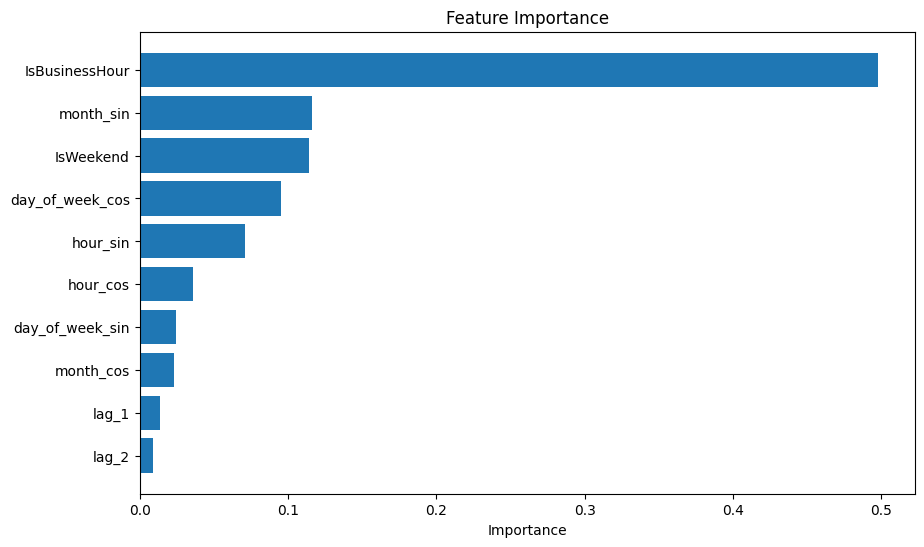

In [28]:
feature_importance = pd.DataFrame({
    'Feature': X_train_ful.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [29]:
evaluation_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Time': df2['Delivery Date Hour'].iloc[split_idx:]
})
evaluation_df.head()

,Actual,Predicted,Time
2080,0.0,0.0,2024-12-26 18:00:00
2081,0.0,0.0,2024-12-26 21:00:00
2082,0.0,0.0,2024-12-27 00:00:00
2083,0.0,0.0,2024-12-27 03:00:00
2084,0.0,0.0,2024-12-27 06:00:00


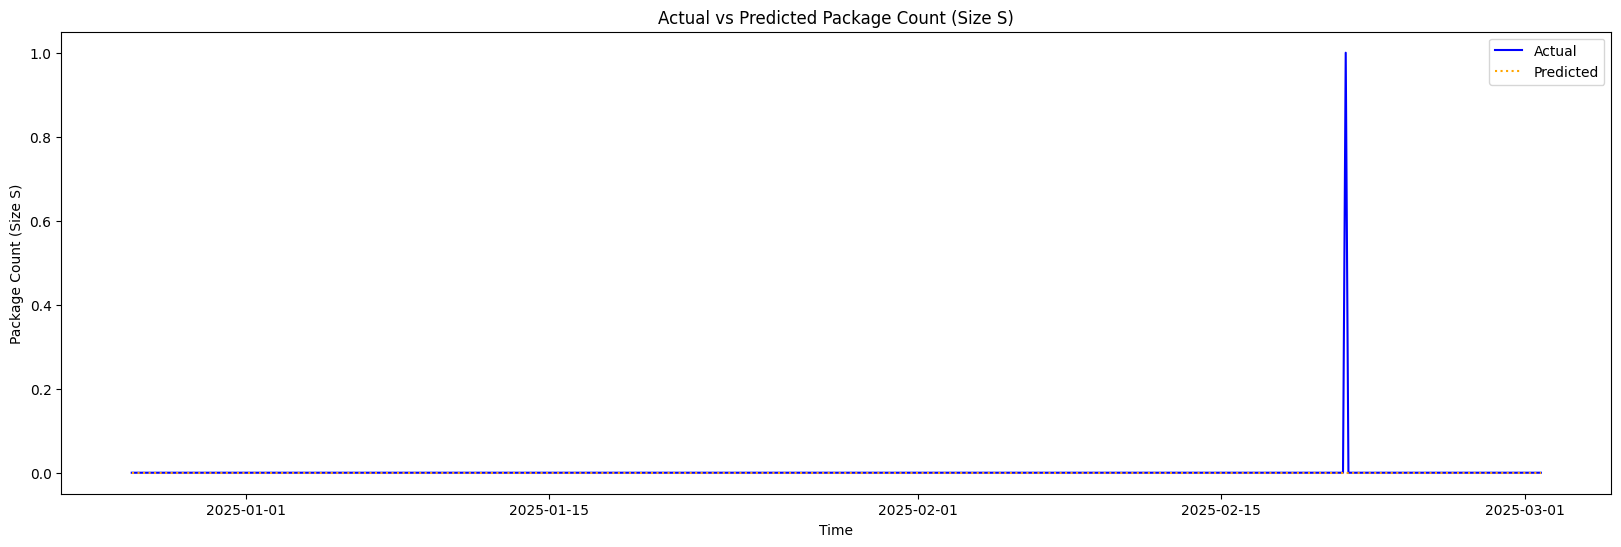

In [30]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=evaluation_df, x='Time', y='Actual', label='Actual', color='blue')
sns.lineplot(data=evaluation_df, x='Time', y='Predicted', label='Predicted', color='orange', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Package Count (Size S)')
plt.title('Actual vs Predicted Package Count (Size S)')
plt.legend()
plt.show()

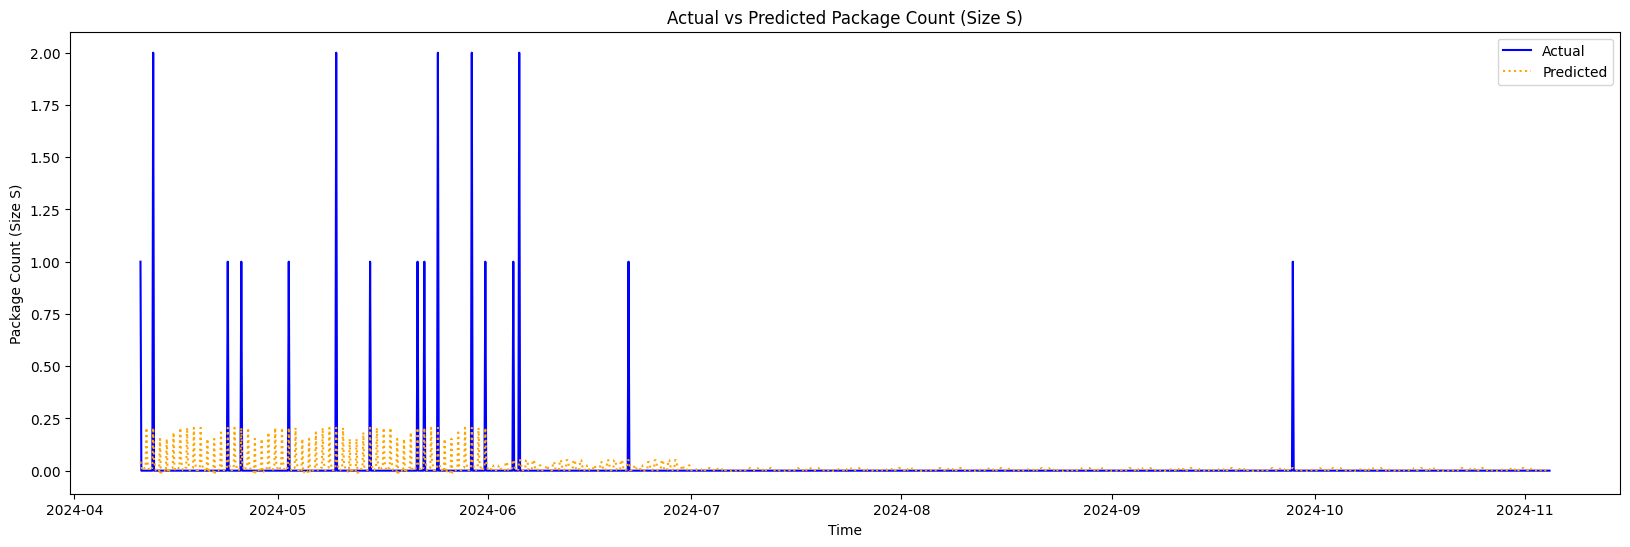

In [31]:
# Plot the predictions vs actuals
y_pred = best_model.predict(X_train)

evaluation_df = pd.DataFrame({
    'Actual': y_train,
    'Predicted': y_pred,
    'Time': df2['Delivery Date Hour'].iloc[:len(y_train)]
})

plt.figure(figsize=(20, 6))
sns.lineplot(data=evaluation_df, x='Time', y='Actual', label='Actual', color='blue')
sns.lineplot(data=evaluation_df, x='Time', y='Predicted', label='Predicted', color='orange', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Package Count (Size S)')
plt.title('Actual vs Predicted Package Count (Size S)')
plt.legend()
plt.show()